In [1]:
! pip install -U pandas matplotlib seaborn yfinance sqlalchemy psycopg2-binary

In [2]:
from matplotlib import pyplot as plt
import yfinance as yf

import os
from sqlalchemy import create_engine

# Example credentials (adjust to match your actual config)
user = "stockroulette_user"
password = "ChangeMe123!"
host = "localhost"  # or your EC2 hostname or Docker host
port = "5432"
db = "stockroulette"

# SQLAlchemy connection string
DATABASE_URL = f"postgresql://{user}:{password}@{host}:{port}/{db}"
# Create engine
engine = create_engine(DATABASE_URL)

In [3]:
import pandas as pd
import glob # For finding files matching a pattern
import os   # For path manipulation (optional, but useful for more complex scenarios)

directory_path = 'data/stocks/' # Replace with your actual directory
file_pattern = os.path.join(directory_path, '*.csv') # Matches all .csv files
csv_files = glob.glob(file_pattern)

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

In [4]:
import os

# Extract ticker symbol from file path and add as a column to each dataframe before concatenation
# Since combined_df is already created, let's reconstruct the ticker info

# Create a mapping from file path to ticker

# Build a mapping from file path to ticker
file_to_ticker = {f: os.path.splitext(os.path.basename(f))[0] for f in csv_files}

# Create a Series of tickers for each row in combined_df
# First, build a list of ticker for each row in each original df, then concatenate
ticker_list = []
for file, df_part in zip(csv_files, dfs):
    ticker = file_to_ticker[file]
    ticker_list.extend([ticker] * len(df_part))  # Fix: use len(df_part) instead of len(dfs)

# Add the ticker column to combined_stocks_with_sp500
combined_df = combined_df.copy()
combined_df['Ticker'] = ticker_list

# Group by year and month, count unique tickers
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Year'] = combined_df['Date'].dt.year
combined_df['Month'] = combined_df['Date'].dt.month

In [5]:
# Filter combined_df for years between 2000 and 2020 (inclusive)
tickers_2000_2020_df = combined_df[(combined_df['Year'] >= 2000) & (combined_df['Year'] <= 2020)]
tickers_2000_2020_df

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month
30,2000-01-03,56.330471,56.464592,48.193848,51.502148,44.294170,4674300.0,A,2000,1
31,2000-01-04,48.730328,49.266811,46.316166,47.567955,40.910591,4765000.0,A,2000,1
32,2000-01-05,47.389126,47.567955,43.141987,44.617310,38.372894,5758600.0,A,2000,1
33,2000-01-06,44.080830,44.349072,41.577251,42.918453,36.911816,2534400.0,A,2000,1
34,2000-01-07,42.247852,47.165592,42.203148,46.494991,39.987797,2819600.0,A,2000,1
...,...,...,...,...,...,...,...,...,...,...
24197437,2020-03-26,10.230000,11.430000,10.230000,11.100000,11.100000,189500.0,ZYXI,2020,3
24197438,2020-03-27,10.700000,10.980000,10.060000,10.300000,10.300000,145000.0,ZYXI,2020,3
24197439,2020-03-30,10.160000,11.060000,10.160000,10.800000,10.800000,162300.0,ZYXI,2020,3
24197440,2020-03-31,10.680000,11.140000,10.590000,11.070000,11.070000,280400.0,ZYXI,2020,3


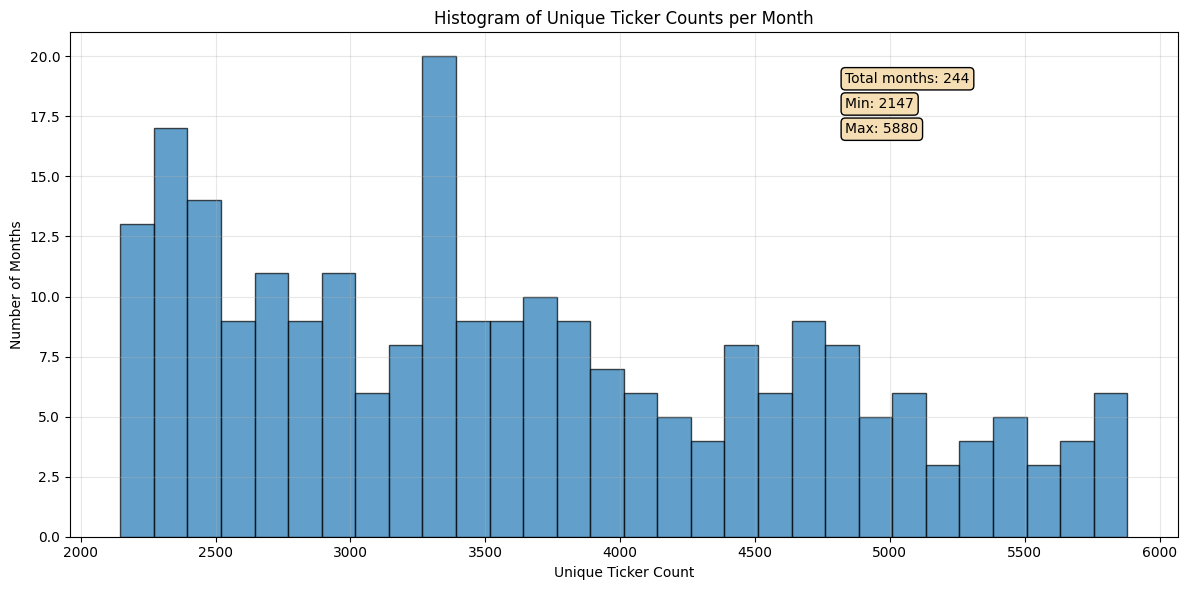

First few bin edges: [2147.         2271.43333333 2395.86666667 2520.3        2644.73333333]
Last few bin edges: [5382.26666667 5506.7        5631.13333333 5755.56666667 5880.        ]


In [6]:
unique_ticker_counts = (
    tickers_2000_2020_df.groupby(['Year', 'Month'])['Ticker']
    .nunique()
    .reset_index(name='UniqueTickerCount')
)
# Create a better histogram with more appropriate binning
plt.figure(figsize=(12, 6))

# Use bins that start from the minimum value
min_val = unique_ticker_counts['UniqueTickerCount'].min()
max_val = unique_ticker_counts['UniqueTickerCount'].max()

# Create 30 bins from min to max
bins = plt.hist(unique_ticker_counts['UniqueTickerCount'], bins=30, 
                edgecolor='black', alpha=0.7)

plt.title('Histogram of Unique Ticker Counts per Month')
plt.xlabel('Unique Ticker Count')
plt.ylabel('Number of Months')
plt.grid(True, alpha=0.3)

# Add some statistics as text
plt.text(0.7, 0.9, f'Total months: {len(unique_ticker_counts)}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
plt.text(0.7, 0.85, f'Min: {min_val}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
plt.text(0.7, 0.8, f'Max: {max_val}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

plt.tight_layout()
plt.show()

# Print the first few bin edges to see what the leftmost bar represents
print("First few bin edges:", bins[1][:5])
print("Last few bin edges:", bins[1][-5:])

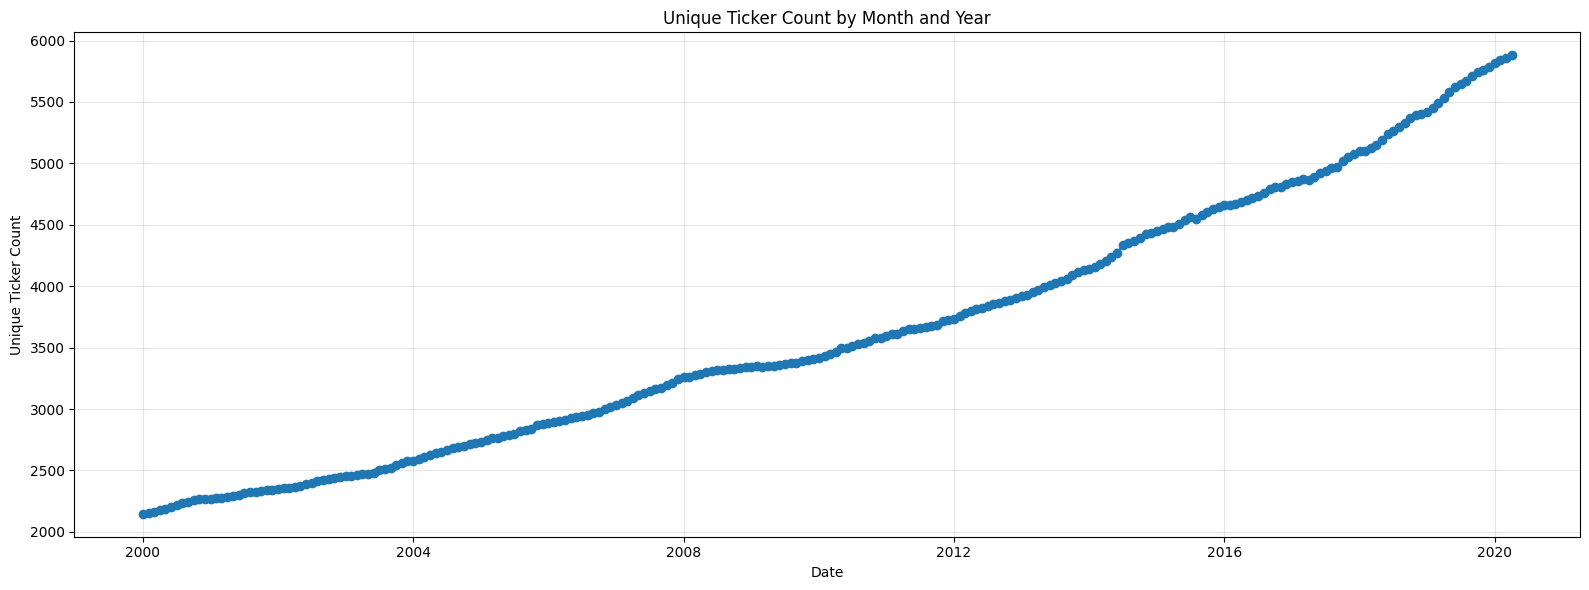

In [7]:
plt.figure(figsize=(16, 6))
plt.plot(
    pd.to_datetime(unique_ticker_counts['Year'].astype(str) + '-' + unique_ticker_counts['Month'].astype(str) + '-01'),
    unique_ticker_counts['UniqueTickerCount'],
    marker='o', linestyle='-'
)
plt.title('Unique Ticker Count by Month and Year')
plt.xlabel('Date')
plt.ylabel('Unique Ticker Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
meta_df = pd.read_csv('data/symbols_valid_meta.csv')
meta_df

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N
...,...,...,...,...,...,...,...,...,...,...,...,...
8044,Y,ZUO,"Zuora, Inc. Class A Common Stock",N,,N,100.0,N,NaN,ZUO,ZUO,N
8045,Y,ZVO,Zovio Inc. - Common Stock,Q,Q,N,100.0,N,N,NaN,ZVO,N
8046,Y,ZYME,Zymeworks Inc. Common Shares,N,,N,100.0,N,NaN,ZYME,ZYME,N
8047,Y,ZYNE,"Zynerba Pharmaceuticals, Inc. - Common Stock",Q,G,N,100.0,N,N,NaN,ZYNE,N


In [9]:
stocks_df = pd.merge(left=tickers_2000_2020_df, right= meta_df, left_on='Ticker', right_on='NASDAQ Symbol', how='left')
stocks_df

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,...,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,2000-01-03,56.330471,56.464592,48.193848,51.502148,44.294170,4674300.0,A,2000,1,...,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,2000-01-04,48.730328,49.266811,46.316166,47.567955,40.910591,4765000.0,A,2000,1,...,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
2,2000-01-05,47.389126,47.567955,43.141987,44.617310,38.372894,5758600.0,A,2000,1,...,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
3,2000-01-06,44.080830,44.349072,41.577251,42.918453,36.911816,2534400.0,A,2000,1,...,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
4,2000-01-07,42.247852,47.165592,42.203148,46.494991,39.987797,2819600.0,A,2000,1,...,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18373353,2020-03-26,10.230000,11.430000,10.230000,11.100000,11.100000,189500.0,ZYXI,2020,3,...,"Zynex, Inc. - Common Stock",Q,S,N,100.0,N,N,NaN,ZYXI,N
18373354,2020-03-27,10.700000,10.980000,10.060000,10.300000,10.300000,145000.0,ZYXI,2020,3,...,"Zynex, Inc. - Common Stock",Q,S,N,100.0,N,N,NaN,ZYXI,N
18373355,2020-03-30,10.160000,11.060000,10.160000,10.800000,10.800000,162300.0,ZYXI,2020,3,...,"Zynex, Inc. - Common Stock",Q,S,N,100.0,N,N,NaN,ZYXI,N
18373356,2020-03-31,10.680000,11.140000,10.590000,11.070000,11.070000,280400.0,ZYXI,2020,3,...,"Zynex, Inc. - Common Stock",Q,S,N,100.0,N,N,NaN,ZYXI,N


In [10]:
# remove rows with NaN in 'Open' column and filter out 'Test Issue' and 'ETF'
stocks_df = stocks_df.dropna(subset=['Open'])
stocks_df = stocks_df[(stocks_df['Test Issue'] != 'Y') & (stocks_df['ETF'] != 'Y')].copy()
stocks_df = stocks_df[
    (stocks_df['Test Issue'] != 'Y') &
    (stocks_df['ETF'] != 'Y') &
    (stocks_df['Nasdaq Traded'] == 'Y') &
    (stocks_df['Financial Status'] == 'N')  # only financially normal
]
stocks_df.shape

(7940041, 22)

In [11]:
sp500_df = pd.read_csv('data/sp500_full.csv')
sp500_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date Added,CIK,Founded
0,MMM,|3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,|A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,|Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,|AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,|Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
239,WBD,|Warner Bros. Discovery,Communication Services,Broadcasting,"New York City, New York",2022-04-11,1437107,2022 (Warner Bros. 1923)
240,WM,"|Waste Management, Inc.|Waste Management",Industrials,Environmental & Facilities Services,"Houston, Texas",1998-08-31,823768,1968
241,WAT,|Waters Corporation,Health Care,Life Sciences Tools & Services,"Milford, Massachusetts",2002-01-02,1000697,1958
242,XEL,|Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909


In [12]:
stocks_with_sp500 = pd.merge(left=stocks_df,right=sp500_df, left_on='Symbol', right_on='Symbol', how='left')
stocks_with_sp500

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,...,CQS Symbol,NASDAQ Symbol,NextShares,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date Added,CIK,Founded
0,2019-03-11,1.08,1.10,1.08,1.08,1.08,32100.0,AACG,2019,3,...,NaN,AACG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-03-12,1.08,1.09,1.05,1.05,1.05,20200.0,AACG,2019,3,...,NaN,AACG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-13,1.06,1.08,1.04,1.07,1.07,23100.0,AACG,2019,3,...,NaN,AACG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-14,1.06,1.11,1.06,1.08,1.08,29900.0,AACG,2019,3,...,NaN,AACG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-15,1.06,1.08,1.04,1.04,1.04,30900.0,AACG,2019,3,...,NaN,AACG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7940036,2020-03-26,10.23,11.43,10.23,11.10,11.10,189500.0,ZYXI,2020,3,...,NaN,ZYXI,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7940037,2020-03-27,10.70,10.98,10.06,10.30,10.30,145000.0,ZYXI,2020,3,...,NaN,ZYXI,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7940038,2020-03-30,10.16,11.06,10.16,10.80,10.80,162300.0,ZYXI,2020,3,...,NaN,ZYXI,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7940039,2020-03-31,10.68,11.14,10.59,11.07,11.07,280400.0,ZYXI,2020,3,...,NaN,ZYXI,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
import pandas as pd
import numpy as np

def drop_broken_tickers(df, price_col='Close', min_days=100, min_median_price=1.0,
                        max_zero_ratio=0.02, max_volatility=0.5, max_price_ratio=1000,
                        min_price_ratio=50, max_flat_period=0.15):
    """
    Drop tickers with broken price data or extreme volatility.
    
    Parameters:
    - max_price_ratio: maximum ratio between max and min price (to catch extreme price swings)
    - min_price_ratio: minimum ratio to flag as suspicious (catches moderate drops)
    - max_flat_period: maximum fraction of days that can have the same price
    """
    def is_broken(sub_df):
        if len(sub_df) < min_days:
            return True
        if sub_df[price_col].median() < min_median_price:
            return True
        
        # Check for zero/near-zero prices (more strict threshold)
        zero_ratio = (sub_df[price_col] <= 0.01).mean()
        if zero_ratio > max_zero_ratio:
            return True
        
        # Check for extreme price ratios (max/min > threshold)
        price_min = sub_df[price_col].min()
        price_max = sub_df[price_col].max()
        if price_min > 0 and (price_max / price_min) > max_price_ratio:
            return True
        
        # Check for suspicious moderate price drops combined with flat periods
        if price_min > 0 and (price_max / price_min) > min_price_ratio:
            # Additional check: look for extended flat periods at low prices
            low_price_threshold = price_min * 1.1  # Within 10% of minimum
            low_price_days = (sub_df[price_col] <= low_price_threshold).sum()
            if low_price_days / len(sub_df) > max_flat_period:
                return True
            
        # Check if last price is near zero
        if sub_df[price_col].iloc[-1] <= 0.01:
            return True
            
        # Check for volatility (compute it here to avoid groupby issues)
        sub_df_sorted = sub_df.sort_values('Date')
        returns = np.log(sub_df_sorted[price_col]) - np.log(sub_df_sorted[price_col].shift(1))
        volatility = returns.std()
        if pd.notna(volatility) and volatility > max_volatility:
            return True
        
        # Check for long price plateaus (any single price appears too frequently)
        if sub_df[price_col].value_counts(normalize=True).iloc[0] > 0.3:
            return True
            
        # Check for sudden large drops (price changes > 50% in single day)
        daily_changes = sub_df_sorted[price_col].pct_change().abs()
        if (daily_changes > 0.5).any():
            return True
            
        return False

    # Collect broken tickers manually
    bad_tickers = [
        ticker for ticker, sub_df in df.groupby('Ticker')
        if is_broken(sub_df)
    ]
    print(f"Dropping {len(bad_tickers)} broken/volatile tickers: {bad_tickers[:10]}...")

    return df[~df['Ticker'].isin(bad_tickers)].copy()


clean_df = drop_broken_tickers(stocks_with_sp500)

Dropping 1065 broken/volatile tickers: ['AACG', 'AAL', 'AAPL', 'ABEO', 'ABIO', 'ABUS', 'ACAD', 'ACER', 'ACHC', 'ACIU']...


In [14]:
clean_df = clean_df[['Ticker','Security Name', 'Year','Month','Date','Close','Security',]].copy()
clean_df['Security Name'] = clean_df['Security Name'].str.strip()

In [15]:
# Calculate the date range for each ticker in stock_popular_df
date_ranges = clean_df.groupby('Ticker')['Date'].agg(['min', 'max']).reset_index()
date_ranges.columns = ['Ticker', 'StartDate', 'EndDate']
date_ranges['listed_days'] = date_ranges.apply(
    lambda row: row['EndDate'] -row['StartDate'],
    axis=1
)
date_ranges.sort_values(by='Ticker', ascending=True, inplace=True)
date_ranges.to_csv('data/ticker_date_ranges.csv', index=False)

In [16]:
# stocks_with_sp500[stocks_with_sp500['Security'].isna() == False].groupby(['Year', 'Month'])['Ticker'].nunique().reset_index(name='UniqueTickerCount')
stock_popular_df = clean_df[clean_df['Security'].isna() == False]
# stock_popular_df = stock_popular_df[['Ticker','Security Name','Date','Close']].copy()
print(stock_popular_df[['Ticker','Security Name']].value_counts().shape)
stock_popular_df.to_csv('data/stocks_popular.csv', index=False)

(52,)


In [17]:
stock_popular_df = stock_popular_df.rename(columns={
    'Ticker': 'symbol',  
    'Security Name': 'company_name',
    'Date': 'date',
    'Close': 'price'
})
stock_popular_df['category'] = 'popular'
stock_popular_df[['symbol','date','price']].to_sql("stock_prices",con=engine,  if_exists="replace", index=False)


404

In [18]:
# Calculate the date range for each ticker in stock_popular_df
date_ranges = stock_popular_df.groupby('symbol')['date'].agg(['min', 'max']).reset_index()
date_ranges.columns = ['symbol', 'available_from', 'available_to']
date_ranges['listed_days'] = date_ranges.apply(
    lambda row: row['available_to'] -row['available_from'],
    axis=1
)
date_ranges.sort_values(by='symbol', ascending=True, inplace=True)
# date_ranges.to_csv('data/ticker_date_ranges.csv', index=False)
date_ranges

,symbol,available_from,available_to,listed_days
0,ADBE,2000-01-03,2020-04-01,7394 days
1,AKAM,2000-01-03,2020-04-01,7394 days
2,ALGN,2001-01-30,2020-04-01,7001 days
3,AMZN,2000-01-03,2020-04-01,7394 days
4,BKNG,2000-01-03,2020-04-01,7394 days
5,CDW,2013-06-27,2020-04-01,2470 days
6,CHTR,2010-01-05,2020-04-01,3739 days
7,COST,2000-01-03,2020-04-01,7394 days
8,CPRT,2000-01-03,2020-04-01,7394 days
9,CRWD,2019-06-12,2020-04-01,294 days


In [19]:
stocks_popular_meta_df = pd.merge(left=stock_popular_df[['symbol','company_name','category']], right=date_ranges[['symbol', 'available_from', 'available_to']],
         left_on='symbol', right_on='symbol', how='left')

stocks_popular_meta_df = stocks_popular_meta_df.drop_duplicates()
stocks_popular_meta_df.to_sql(name="stocks", con=engine, if_exists="append", index=False)

52

In [20]:
stock_popular_df

,symbol,company_name,Year,Month,date,price,Security,category
105902,ADBE,Adobe Inc. - Common Stock,2000,1,2000-01-03,16.390625,|Adobe Inc.,popular
105903,ADBE,Adobe Inc. - Common Stock,2000,1,2000-01-04,15.015625,|Adobe Inc.,popular
105904,ADBE,Adobe Inc. - Common Stock,2000,1,2000-01-05,15.312500,|Adobe Inc.,popular
105905,ADBE,Adobe Inc. - Common Stock,2000,1,2000-01-06,15.437500,|Adobe Inc.,popular
105906,ADBE,Adobe Inc. - Common Stock,2000,1,2000-01-07,16.187500,|Adobe Inc.,popular
...,...,...,...,...,...,...,...,...
7821027,XEL,Xcel Energy Inc. - Common Stock,2020,3,2020-03-26,57.910000,|Xcel Energy,popular
7821028,XEL,Xcel Energy Inc. - Common Stock,2020,3,2020-03-27,58.770000,|Xcel Energy,popular
7821029,XEL,Xcel Energy Inc. - Common Stock,2020,3,2020-03-30,62.560001,|Xcel Energy,popular
7821030,XEL,Xcel Energy Inc. - Common Stock,2020,3,2020-03-31,60.299999,|Xcel Energy,popular


In [21]:
import pandas as pd
import numpy as np

df = clean_df[clean_df['Security'].isna()].copy()

# Assumes df has columns: ['ticker', 'date', 'Open', 'High', 'Low', 'Close', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])

# Sort values to compute returns properly
df = df.sort_values(by=['Ticker', 'Date'])

# Compute daily log returns
df['log_return'] = df.groupby('Ticker')['Close'].transform(lambda x: np.log(x) - np.log(x.shift(1)))

# Drop NaNs resulting from shift()
df = df.dropna(subset=['log_return'])

# Compute volatility per ticker (standard deviation of log returns)
volatility = df.groupby('Ticker')['log_return'].std().reset_index()
volatility.columns = ['Ticker', 'volatility']

# Classify top 10% as volatile
threshold = volatility['volatility'].quantile(0.90)
volatile_tickers = volatility[volatility['volatility'] >= threshold]

# Show or save the tickers
volatile_tickers.sort_values('volatility', ascending=False)

,Ticker,volatility
1235,RAPT,0.112972
1568,VIE,0.092667
1369,SNDL,0.091983
217,CABA,0.084780
150,BCEL,0.081184
...,...,...
117,ATLC,0.048295
746,IMVTU,0.048177
0,AAME,0.048093
644,GSKY,0.048077


In [22]:
stock_volatile_df = pd.merge(left=clean_df, right=volatile_tickers, on='Ticker', how='right')
print(stock_volatile_df['Ticker'].value_counts().shape)
stock_volatile_df.to_csv('data/stocks_volatile.csv', index=False)

(167,)


In [23]:
stock_volatile_df

,Ticker,Security Name,Year,Month,Date,Close,Security,volatility
0,AAME,Atlantic American Corporation - Common Stock,2000,1,2000-01-03,2.3125,NaN,0.048093
1,AAME,Atlantic American Corporation - Common Stock,2000,1,2000-01-04,2.3750,NaN,0.048093
2,AAME,Atlantic American Corporation - Common Stock,2000,1,2000-01-05,2.4375,NaN,0.048093
3,AAME,Atlantic American Corporation - Common Stock,2000,1,2000-01-06,2.3125,NaN,0.048093
4,AAME,Atlantic American Corporation - Common Stock,2000,1,2000-01-07,2.3750,NaN,0.048093
...,...,...,...,...,...,...,...,...
127846,ZKIN,"ZK International Group Co., Ltd - Ordinary Share",2020,3,2020-03-26,0.8800,NaN,0.050853
127847,ZKIN,"ZK International Group Co., Ltd - Ordinary Share",2020,3,2020-03-27,0.8230,NaN,0.050853
127848,ZKIN,"ZK International Group Co., Ltd - Ordinary Share",2020,3,2020-03-30,0.8230,NaN,0.050853
127849,ZKIN,"ZK International Group Co., Ltd - Ordinary Share",2020,3,2020-03-31,0.8800,NaN,0.050853


In [24]:
stock_volatile_df = stock_volatile_df.rename(columns={
    'Ticker': 'symbol',  
    'Security Name': 'company_name',
    'Date': 'date',
    'Close': 'price'
})
stock_volatile_df['category'] = 'volatile'
stock_volatile_df[['symbol','date','price']].to_sql("stock_prices",con=engine,  if_exists="append", index=False)


851

In [25]:
# Calculate the date range for each ticker in stock_popular_df
date_ranges = stock_volatile_df.groupby('symbol')['date'].agg(['min', 'max']).reset_index()
date_ranges.columns = ['symbol', 'available_from', 'available_to']
date_ranges['listed_days'] = date_ranges.apply(
    lambda row: row['available_to'] -row['available_from'],
    axis=1
)
date_ranges.sort_values(by='symbol', ascending=True, inplace=True)
# date_ranges.to_csv('data/ticker_date_ranges.csv', index=False)
date_ranges

,symbol,available_from,available_to,listed_days
0,AAME,2000-01-03,2020-04-01,7394 days
1,ACMR,2017-11-02,2020-04-01,881 days
2,ADPT,2019-06-27,2020-04-01,279 days
3,ADRO,2015-04-15,2020-04-01,1813 days
4,AEHR,2000-01-03,2020-04-01,7394 days
...,...,...,...,...
162,XAIR,2018-06-12,2020-04-01,659 days
163,XERS,2018-06-21,2020-04-01,650 days
164,XPEL,2019-07-01,2020-04-01,275 days
165,YGYIP,2019-09-20,2020-04-01,194 days


In [26]:
stock_volatile_meta_df = pd.merge(left=stock_volatile_df[['symbol','company_name','category']], right=date_ranges[['symbol', 'available_from', 'available_to']],
         left_on='symbol', right_on='symbol', how='left')

stock_volatile_meta_df = stock_volatile_meta_df.drop_duplicates()
stock_volatile_meta_df.to_sql(name="stocks", con=engine, if_exists="append", index=False)

167

Text(0.5, 1.0, 'Distribution of Ticker Volatility')

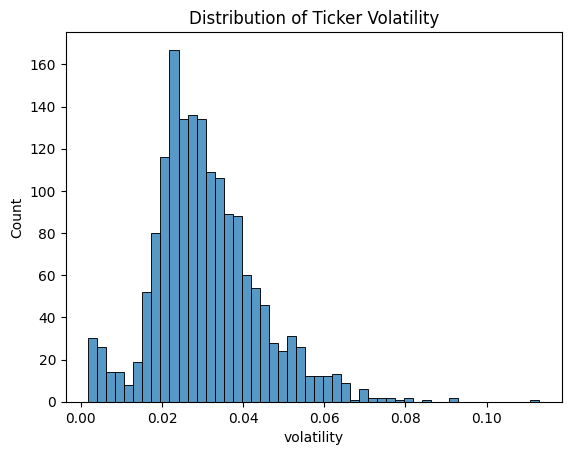

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(volatility['volatility'], bins=50)
plt.title("Distribution of Ticker Volatility")


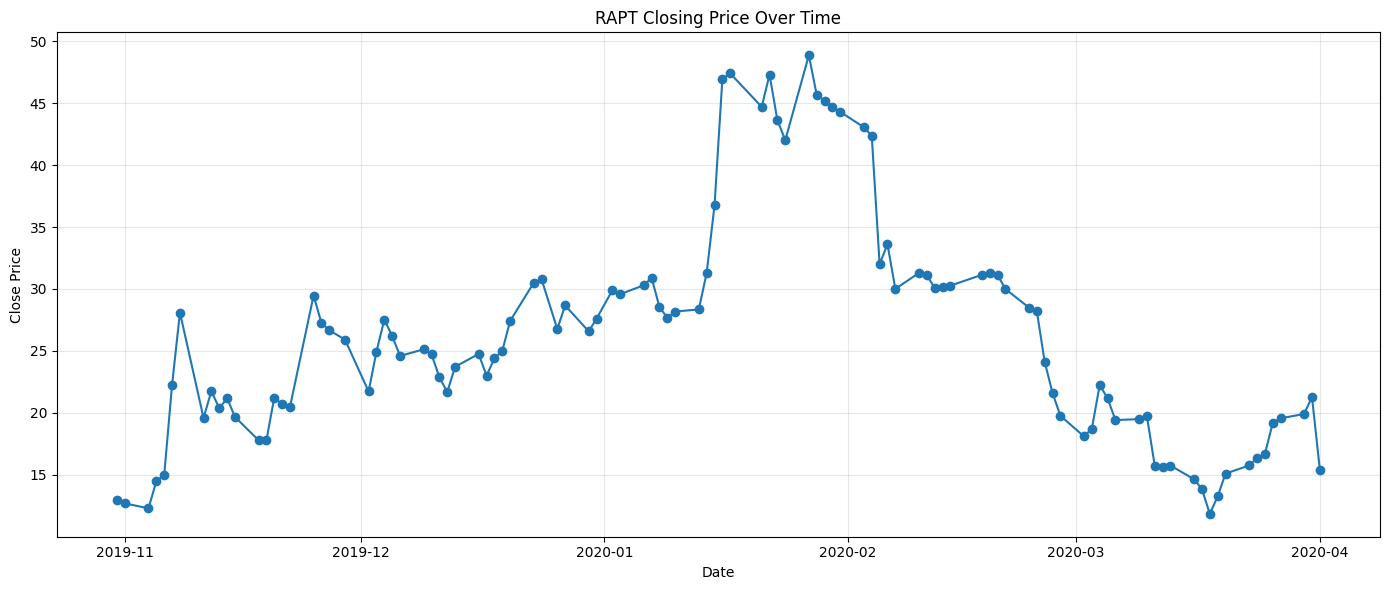

In [28]:
ticker = 'RAPT'
pae_df = stocks_with_sp500[stocks_with_sp500['Ticker'] == ticker]
plt.figure(figsize=(14, 6))
plt.plot(pae_df['Date'], pae_df['Close'], marker='o', linestyle='-')
plt.title(f'{ticker} Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
# Remove rows from clean_df that are in either stock_volatile_df or stock_popular_df
volatile_tickers_set = set(stock_volatile_df['symbol'].unique())
popular_tickers_set = set(stock_popular_df['symbol'].unique())
exclude_tickers = volatile_tickers_set.union(popular_tickers_set)

cleaned_exclusive_df = clean_df[~clean_df['Ticker'].isin(exclude_tickers)].copy()
cleaned_exclusive_df

,Ticker,Security Name,Year,Month,Date,Close,Security
9008,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-26,9.960000,NaN
9009,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-27,10.100000,NaN
9010,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-30,10.000000,NaN
9011,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-01,10.000000,NaN
9012,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-02,9.970000,NaN
...,...,...,...,...,...,...,...
7934565,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-26,18.639999,NaN
7934566,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-27,17.469999,NaN
7934567,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-30,17.430000,NaN
7934568,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-31,17.320000,NaN


In [33]:
cleaned_exclusive_df['Ticker'].value_counts()

Ticker
ZIXI     5094
ZION     5094
AAON     5094
XLNX     5094
WWD      5094
         ... 
FSRVU     104
APXT      102
EXPC      102
QK        102
ORSN      100
Name: count, Length: 1502, dtype: int64

In [34]:
cleaned_exclusive_df

,Ticker,Security Name,Year,Month,Date,Close,Security
9008,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-26,9.960000,NaN
9009,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-27,10.100000,NaN
9010,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-30,10.000000,NaN
9011,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-01,10.000000,NaN
9012,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-02,9.970000,NaN
...,...,...,...,...,...,...,...
7934565,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-26,18.639999,NaN
7934566,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-27,17.469999,NaN
7934567,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-30,17.430000,NaN
7934568,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-31,17.320000,NaN


In [35]:
unique_ticker = pd.DataFrame(cleaned_exclusive_df['Ticker'].unique(), columns=['Ticker'])

In [ ]:
# yf.Ticker(ticker).info

In [36]:
import time
import random

def get_sector(ticker):
    try:
        # Add random delay to avoid rate limiting
        time.sleep(random.uniform(0.1, 0.5))
        
        # print(f"Fetching sector for {ticker}")
        
        # Use yfinance to get the sector information
        ticker_obj = yf.Ticker(ticker)
        info = ticker_obj.info
        
        # Check if info is empty or if sector is available
        if not info:
            # print(f"No info available for {ticker}")
            return pd.NA
            
        sector = info.get('sector')
        if sector:
            # print(f"Found sector for {ticker}: {sector}")
            return sector
        else:
            # print(f"No sector info for {ticker}")
            return pd.NA
            
    except Exception as e:
        error_msg = str(e)
        
        # Handle specific error types
        if "404" in error_msg:
            # print(f"Ticker {ticker} not found (404)")
            return pd.NA
        elif "Rate limited" in error_msg or "Too Many Requests" in error_msg:
            # print(f"Rate limited for {ticker}, waiting and retrying...")
            time.sleep(2)  # Wait 2 seconds
            try:
                # Retry once
                ticker_obj = yf.Ticker(ticker)
                info = ticker_obj.info
                sector = info.get('sector') if info else None
                return sector if sector else pd.NA
            except Exception as retry_e:
                # print(f"Retry failed for {ticker}: {retry_e}")
                return "Error"
        else:
            # print(f"Error fetching sector for {ticker}: {e}")
            return "Error"

# Apply with progress tracking
print(f"Starting to fetch sectors for {len(unique_ticker)} tickers...")
unique_ticker['Sector'] = unique_ticker['Ticker'].apply(get_sector)
print("Finished fetching sectors!")

Starting to fetch sectors for 1502 tickers...


HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 


Finished fetching sectors!


In [37]:
unique_ticker.to_csv('data/tickers_with_sectors.csv', index=False)

In [ ]:
unique_ticker = pd.read_csv('data/tickers_with_sectors.csv')

In [38]:
print(unique_ticker.shape)
print(unique_ticker.isna().sum())
print(unique_ticker['Sector'].unique())
unique_ticker[unique_ticker['Sector'].isna()]

(1502, 2)
Ticker      0
Sector    523
dtype: int64
['Technology' 'Industrials' <NA> 'Financial Services' 'Healthcare'
 'Real Estate' 'Consumer Defensive' 'Communication Services'
 'Consumer Cyclical' 'Utilities' 'Basic Materials' 'Energy']


,Ticker,Sector
2,AAWW,<NA>
3,AAXN,<NA>
5,ABMD,<NA>
6,ABTX,<NA>
7,ACAM,<NA>
...,...,...
1492,ZIONN,<NA>
1493,ZIONO,<NA>
1495,ZIV,<NA>
1496,ZIXI,<NA>


In [39]:
openfigi_api_key = '27c94b04-bb34-4180-8d4c-7ddb89d324ee'

In [40]:
import requests
import time

headers = {
    'Content-Type': 'application/json',
    'X-OPENFIGI-APIKEY': openfigi_api_key
}

def fetch_openfigi_info(ticker_list, batch_size=10):
    """
    Fetch OpenFIGI info for a list of tickers with better error handling
    """
    if isinstance(ticker_list, pd.Series):
        ticker_list = ticker_list.tolist()
    
    results = []
    
    # Process in batches to avoid overwhelming the API
    for i in range(0, len(ticker_list), batch_size):
        batch = ticker_list[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}: {len(batch)} tickers")
        
        jobs = [{"idType": "TICKER", "idValue": ticker} for ticker in batch]
        
        try:
            response = requests.post('https://api.openfigi.com/v3/mapping', 
                                   headers=headers, 
                                   json=jobs,
                                   timeout=30)
            
            print(f"Response status: {response.status_code}")
            
            if response.status_code == 200:
                try:
                    batch_results = response.json()
                    results.extend(batch_results)
                    print(f"Successfully processed {len(batch)} tickers")
                except requests.exceptions.JSONDecodeError:
                    print(f"JSON decode error for batch. Response text: {response.text[:200]}...")
                    # Add None results for this batch
                    results.extend([None] * len(batch))
            elif response.status_code == 429:
                print("Rate limited. Waiting 60 seconds...")
                time.sleep(60)
                # Retry this batch
                try:
                    response = requests.post('https://api.openfigi.com/v3/mapping', 
                                           headers=headers, 
                                           json=jobs,
                                           timeout=30)
                    if response.status_code == 200:
                        batch_results = response.json()
                        results.extend(batch_results)
                    else:
                        print(f"Retry failed with status: {response.status_code}")
                        results.extend([None] * len(batch))
                except Exception as retry_e:
                    print(f"Retry failed: {retry_e}")
                    results.extend([None] * len(batch))
            else:
                print(f"API error {response.status_code}: {response.text[:200]}...")
                results.extend([None] * len(batch))
                
        except requests.exceptions.Timeout:
            print(f"Timeout for batch {i//batch_size + 1}")
            results.extend([None] * len(batch))
        except Exception as e:
            print(f"Error processing batch {i//batch_size + 1}: {e}")
            results.extend([None] * len(batch))
        
        # Rate limiting - wait between batches
        if i + batch_size < len(ticker_list):
            print("Waiting 1 second before next batch...")
            time.sleep(1)
    
    return results

# Test with a small batch first
print("Testing with a small batch...")
test_result = fetch_openfigi_info(["AAPL", "TSLA"])

Testing with a small batch...
Processing batch 1: 2 tickers
Response status: 200
Successfully processed 2 tickers


In [41]:
# Get tickers that need sector info
missing_sector_tickers = unique_ticker[unique_ticker['Sector'].isna()]['Ticker'].tolist()
openfigi_data = []
print(f"Found {len(missing_sector_tickers)} tickers without sector info")

if len(missing_sector_tickers) > 0:
    # print(f"Sample tickers: {missing_sector_tickers[:5]}")
    
    # Fetch OpenFIGI data with improved error handling
    openfigi_data.append(fetch_openfigi_info(missing_sector_tickers, batch_size=5))
    # print(f"Received {len(openfigi_data)} results from OpenFIGI")
# else:
    # print("No tickers need sector info from OpenFIGI")
    # openfigi_data = []

Found 523 tickers without sector info
Processing batch 1: 5 tickers
Response status: 200
Successfully processed 5 tickers
Waiting 1 second before next batch...
Processing batch 2: 5 tickers
Response status: 200
Successfully processed 5 tickers
Waiting 1 second before next batch...
Processing batch 3: 5 tickers
Response status: 200
Successfully processed 5 tickers
Waiting 1 second before next batch...
Processing batch 4: 5 tickers
Response status: 200
Successfully processed 5 tickers
Waiting 1 second before next batch...
Processing batch 5: 5 tickers
Response status: 200
Successfully processed 5 tickers
Waiting 1 second before next batch...
Processing batch 6: 5 tickers
Response status: 200
Successfully processed 5 tickers
Waiting 1 second before next batch...
Processing batch 7: 5 tickers
Response status: 200
Successfully processed 5 tickers
Waiting 1 second before next batch...
Processing batch 8: 5 tickers
Response status: 200
Successfully processed 5 tickers
Waiting 1 second before 

In [ ]:
cleaned_exclusive_df

,Ticker,Security Name,Year,Month,Date,Close,Security
9008,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-26,9.960000,NaN
9009,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-27,10.100000,NaN
9010,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-30,10.000000,NaN
9011,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-01,10.000000,NaN
9012,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-02,9.970000,NaN
...,...,...,...,...,...,...,...
7934565,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-26,18.639999,NaN
7934566,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-27,17.469999,NaN
7934567,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-30,17.430000,NaN
7934568,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-31,17.320000,NaN


In [42]:
# Simple approach to extract sectors from OpenFIGI data
if openfigi_data and len(openfigi_data) > 0:
    print("Processing OpenFIGI data...")
    
    # Get the actual results (handle nested structure)
    results = openfigi_data[0] if isinstance(openfigi_data[0], list) else openfigi_data
    
    sectors_updated = 0
    
    for i, (ticker, result) in enumerate(zip(missing_sector_tickers, results)):
        if result and isinstance(result, dict) and 'data' in result and result['data']:
            # Get the first match
            first_match = result['data'][0]
            sector = first_match.get('marketSector')
            
            if sector:
                # Update the sector in unique_ticker
                mask = (unique_ticker['Ticker'] == ticker) & (unique_ticker['Sector'].isna())
                if mask.any():
                    unique_ticker.loc[mask, 'Sector'] = sector
                    sectors_updated += 1
                    print(f"Updated {ticker}: {sector}")
    
    print(f"\nUpdated sectors for {sectors_updated} tickers")
    
    # Show updated counts
    print("\nFinal sector counts:")
    print("Total tickers:", len(unique_ticker))
    print("Tickers with sectors:", unique_ticker['Sector'].notna().sum())
    print("Tickers without sectors:", unique_ticker['Sector'].isna().sum())
    
    # Save the updated data
    unique_ticker.to_csv('data/tickers_with_sectors_final.csv', index=False)
    print("\nSaved final ticker data to 'data/tickers_with_sectors_final.csv'")
    
else:
    print("No OpenFIGI data to process")

Processing OpenFIGI data...
Updated ACAM: Equity
Updated ACAMU: Equity
Updated ACIA: Equity
Updated AEGN: Equity
Updated AFIN: Equity
Updated AGBA: Equity
Updated AIH: Equity
Updated AIMT: Equity
Updated ALAC: Equity
Updated ALTR: Equity
Updated ALXN: Equity
Updated ALYA: Equity
Updated AMNB: Equity
Updated AMRB: Equity
Updated AMTBB: Equity
Updated ANDA: Equity
Updated ARCE: Equity
Updated ATRI: Equity
Updated AUTO: Equity
Updated AVID: Equity
Updated BCOM: Equity
Updated BECN: Equity
Updated BGCP: M-Mkt
Updated BKCC: Equity
Updated BMCH: Equity
Updated BMLP: Equity
Updated BOCH: Equity
Updated BPFH: Equity
Updated BRP: Equity
Updated CALB: Equity
Updated CARA: Equity
Updated CARO: Equity
Updated CASA: Equity
Updated CATC: Equity
Updated CBMB: Equity
Updated CCMP: Equity
Updated CDK: Equity
Updated CFFA: Equity
Updated CHNG: Curncy
Updated CLCT: Equity
Updated CNBKA: Equity
Updated CNSL: Equity
Updated CONE: Equity
Updated CONN: Equity
Updated CORE: Equity
Updated CPLP: M-Mkt
Updated 

In [43]:
def process_openfigi_data(openfigi_data, missing_sector_tickers):
    """
    Convert OpenFIGI nested response to a clean DataFrame
    """
    processed_data = []
    
    # Flatten the nested structure
    if openfigi_data and len(openfigi_data) > 0:
        # Get the actual results (first element if it's a list of lists)
        results = openfigi_data[0] if isinstance(openfigi_data[0], list) else openfigi_data
        
        for i, (ticker, result) in enumerate(zip(missing_sector_tickers, results)):
            row = {'Ticker': ticker}
            
            if result is None:
                row.update({
                    'figi': None,
                    'name': None,
                    'marketSector': None,
                    'securityType': None,
                    'exchCode': None,
                    'status': 'No Data'
                })
            elif isinstance(result, dict):
                if 'error' in result:
                    row.update({
                        'figi': None,
                        'name': None,
                        'marketSector': None,
                        'securityType': None,
                        'exchCode': None,
                        'status': f"Error: {result['error']}"
                    })
                elif 'data' in result and result['data']:
                    # Take the first match from the data array
                    first_match = result['data'][0]
                    row.update({
                        'figi': first_match.get('figi'),
                        'name': first_match.get('name'),
                        'marketSector': first_match.get('marketSector'),
                        'securityType': first_match.get('securityType'),
                        'exchCode': first_match.get('exchCode'),
                        'status': 'Success'
                    })
                else:
                    row.update({
                        'figi': None,
                        'name': None,
                        'marketSector': None,
                        'securityType': None,
                        'exchCode': None,
                        'status': 'No Matches'
                    })
            
            processed_data.append(row)
    
    return pd.DataFrame(processed_data)

# Convert to DataFrame
if openfigi_data:
    openfigi_df = process_openfigi_data(openfigi_data, missing_sector_tickers)
    print(f"Created DataFrame with shape: {openfigi_df.shape}")
    print("\nColumns:", openfigi_df.columns.tolist())
    print("\nFirst few rows:")
    print(openfigi_df.head())
    
    # Show sector information found
    sectors_found = openfigi_df[openfigi_df['marketSector'].notna()]
    print(f"\nFound sectors for {len(sectors_found)} tickers:")
    if len(sectors_found) > 0:
        print(sectors_found[['Ticker', 'marketSector', 'name']].head(10))
else:
    print("No OpenFIGI data to process")
    openfigi_df = pd.DataFrame()

Created DataFrame with shape: (523, 7)

Columns: ['Ticker', 'figi', 'name', 'marketSector', 'securityType', 'exchCode', 'status']

First few rows:
  Ticker          figi                          name marketSector  \
0   AAWW          None                          None         None   
1   AAXN          None                          None         None   
2   ABMD          None                          None         None   
3   ABTX          None                          None         None   
4   ACAM  BBG00ZKGBLG8  ACAMAR PARTNERS ACQUISITIO-A       Equity   

   securityType exchCode      status  
0          None     None  No Matches  
1          None     None  No Matches  
2          None     None  No Matches  
3          None     None  No Matches  
4  Common Stock       US     Success  

Found sectors for 200 tickers:
   Ticker marketSector                          name
4    ACAM       Equity  ACAMAR PARTNERS ACQUISITIO-A
5   ACAMU       Equity   ACAMAR PARTNERS ACQUISITION
8    ACIA    

In [44]:
# Check the structure of cleaned_exclusive_df
print("Columns in cleaned_exclusive_df:")
print(cleaned_exclusive_df.columns.tolist())
print(f"\nShape: {cleaned_exclusive_df.shape}")

# If there's no Sector column, we need to add it
if 'Sector' not in cleaned_exclusive_df.columns:
    print("\nSector column not found. Adding sector information...")
    
    # Load the final ticker data with sectors
    try:
        ticker_sectors = pd.read_csv('data/tickers_with_sectors_final.csv')
        print(f"Loaded {len(ticker_sectors)} tickers with sector info")
        
        # Merge sector information
        cleaned_exclusive_df = pd.merge(
            left=cleaned_exclusive_df, 
            right=ticker_sectors[['Ticker', 'Sector']], 
            on='Ticker', 
            how='left'
        )
        print(f"Added Sector column. New shape: {cleaned_exclusive_df.shape}")
        
        # Show sector distribution
        print(f"\nSector distribution:")
        sector_counts = cleaned_exclusive_df['Sector'].value_counts()
        print(f"Tickers with sectors: {cleaned_exclusive_df['Sector'].notna().sum()}")
        print(f"Tickers without sectors: {cleaned_exclusive_df['Sector'].isna().sum()}")
        
    except FileNotFoundError:
        print("Could not find tickers_with_sectors_final.csv file")
        print("Need to run the sector fetching process first")
else:
    print("Sector column already exists")
    
print("\nUpdated cleaned_exclusive_df columns:")
print(cleaned_exclusive_df.columns.tolist())

Columns in cleaned_exclusive_df:
['Ticker', 'Security Name', 'Year', 'Month', 'Date', 'Close', 'Security']

Shape: (4550737, 7)

Sector column not found. Adding sector information...
Loaded 1502 tickers with sector info
Added Sector column. New shape: (4550737, 8)

Sector distribution:
Tickers with sectors: 3942536
Tickers without sectors: 608201

Updated cleaned_exclusive_df columns:
['Ticker', 'Security Name', 'Year', 'Month', 'Date', 'Close', 'Security', 'Sector']


In [45]:
cleaned_exclusive_df.to_csv('data/stocks_with_sectors.csv', index=False)

In [ ]:
cleaned_exclusive_df

,Ticker,Security Name,Year,Month,Date,Close,Security,Sector
0,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-26,9.960000,NaN,Technology
1,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-27,10.100000,NaN,Technology
2,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-30,10.000000,NaN,Technology
3,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-01,10.000000,NaN,Technology
4,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-02,9.970000,NaN,Technology
...,...,...,...,...,...,...,...,...
4550732,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-26,18.639999,NaN,Consumer Cyclical
4550733,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-27,17.469999,NaN,Consumer Cyclical
4550734,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-30,17.430000,NaN,Consumer Cyclical
4550735,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-31,17.320000,NaN,Consumer Cyclical


In [46]:
cleaned_exclusive_df = cleaned_exclusive_df.dropna(subset=['Sector'])
# cleaned_exclusive_df[['Ticker','Security Name','Sector','Date','Open','High','Low','Close','Volume']]
cleaned_exclusive_df.to_csv('data/cleaned_exclusive_stocks_with_sectors_final.csv', index=False)

In [ ]:
cleaned_exclusive_df = cleaned_exclusive_df.rename(columns={
    'Ticker': 'symbol',  
    'Security Name': 'company_name',
    'Date': 'date',
    'Close': 'price',
    'Sector': 'sector'
})
cleaned_exclusive_df['category'] = 'sector'
cleaned_exclusive_df[['symbol','date','price']].to_sql("stock_prices",con=engine,  if_exists="append", index=False)


In [53]:
cleaned_exclusive_df

,symbol,company_name,Year,Month,date,price,Security,sector,category
0,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-26,9.960000,NaN,Technology,sector
1,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-27,10.100000,NaN,Technology,sector
2,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,9,2013-09-30,10.000000,NaN,Technology,sector
3,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-01,10.000000,NaN,Technology,sector
4,AAOI,"Applied Optoelectronics, Inc. - Common Stock",2013,10,2013-10-02,9.970000,NaN,Technology,sector
...,...,...,...,...,...,...,...,...,...
4550732,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-26,18.639999,NaN,Consumer Cyclical,sector
4550733,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-27,17.469999,NaN,Consumer Cyclical,sector
4550734,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-30,17.430000,NaN,Consumer Cyclical,sector
4550735,ZUMZ,Zumiez Inc. - Common Stock,2020,3,2020-03-31,17.320000,NaN,Consumer Cyclical,sector


In [ ]:
# Calculate the date range for each ticker in stock_popular_df
date_ranges = cleaned_exclusive_df.groupby('symbol')['date'].agg(['min', 'max']).reset_index()
date_ranges.columns = ['symbol', 'available_from', 'available_to']
date_ranges['listed_days'] = date_ranges.apply(
    lambda row: row['available_to'] -row['available_from'],
    axis=1
)
date_ranges.sort_values(by='symbol', ascending=True, inplace=True)
# date_ranges.to_csv('data/ticker_date_ranges.csv', index=False)
date_ranges

,symbol,available_from,available_to,listed_days
0,AAOI,2013-09-26,2020-04-01,2379 days
1,AAON,2000-01-03,2020-04-01,7394 days
2,ABCB,2000-01-03,2020-04-01,7394 days
3,ACAM,2019-05-09,2020-04-01,328 days
4,ACAMU,2019-02-22,2020-04-01,404 days
...,...,...,...,...
1174,ZLAB,2017-09-20,2020-04-01,924 days
1175,ZM,2019-04-18,2020-04-01,349 days
1176,ZNGA,2011-12-16,2020-04-01,3029 days
1177,ZS,2018-03-16,2020-04-01,747 days


In [54]:
cleaned_exclusive_meta_df = pd.merge(left=cleaned_exclusive_df[['symbol','company_name','category','sector']], right=date_ranges[['symbol', 'available_from', 'available_to']],
         left_on='symbol', right_on='symbol', how='left')
cleaned_exclusive_meta_df = cleaned_exclusive_meta_df.drop_duplicates()
cleaned_exclusive_meta_df.to_sql(name="stocks", con=engine, if_exists="append", index=False)

179

In [ ]:
# Create a proper DataFrame from OpenFIGI data for analysis
def openfigi_to_dataframe(openfigi_data, ticker_list):
    """
    Convert OpenFIGI response to a clean DataFrame
    """
    rows = []
    
    if openfigi_data and len(openfigi_data) > 0:
        # Handle nested structure
        results = openfigi_data[0] if isinstance(openfigi_data[0], list) else openfigi_data
        
        for ticker, result in zip(ticker_list, results):
            row = {'ticker': ticker}
            
            if result is None:
                row.update({
                    'status': 'no_data',
                    'figi': None,
                    'name': None,
                    'marketSector': None,
                    'securityType': None,
                    'exchCode': None
                })
            elif isinstance(result, dict):
                if 'error' in result:
                    row.update({
                        'status': 'error',
                        'error_message': result['error'],
                        'figi': None,
                        'name': None,
                        'marketSector': None,
                        'securityType': None,
                        'exchCode': None
                    })
                elif 'data' in result and result['data']:
                    # Take first match
                    match = result['data'][0]
                    row.update({
                        'status': 'success',
                        'figi': match.get('figi'),
                        'name': match.get('name'),
                        'marketSector': match.get('marketSector'),
                        'securityType': match.get('securityType'),
                        'exchCode': match.get('exchCode'),
                        'compositeFIGI': match.get('compositeFIGI'),
                        'shareClassFIGI': match.get('shareClassFIGI')
                    })
                else:
                    row.update({
                        'status': 'no_matches',
                        'figi': None,
                        'name': None,
                        'marketSector': None,
                        'securityType': None,
                        'exchCode': None
                    })
            
            rows.append(row)
    
    return pd.DataFrame(rows)

# Create the DataFrame
openfigi_df = openfigi_to_dataframe(openfigi_data, missing_sector_tickers)

print(f"OpenFIGI DataFrame shape: {openfigi_df.shape}")
print(f"\nStatus counts:")
print(openfigi_df['status'].value_counts())

print(f"\nSectors found:")
sectors_df = openfigi_df[openfigi_df['marketSector'].notna()][['ticker', 'marketSector', 'name']]
print(f"Count: {len(sectors_df)}")
if len(sectors_df) > 0:
    print("\nSample:")
    print(sectors_df.head())

# Save for future reference
openfigi_df.to_csv('data/openfigi_results.csv', index=False)
print(f"\nSaved OpenFIGI results to 'data/openfigi_results.csv'")

OpenFIGI DataFrame shape: (523, 9)

Status counts:
status
no_matches    323
success       200
Name: count, dtype: int64

Sectors found:
Count: 200

Sample:
   ticker marketSector                          name
4    ACAM       Equity  ACAMAR PARTNERS ACQUISITIO-A
5   ACAMU       Equity   ACAMAR PARTNERS ACQUISITION
8    ACIA       Equity             ACER INC-GDR 144A
11   AEGN       Equity               AEGEAN AIRLINES
13   AFIN       Equity         ASSOCIATED FINMAN LTD

Saved OpenFIGI results to 'data/openfigi_results.csv'


In [ ]:
unique_ticker = pd.read_csv('data/tickers_with_sectors_final.csv')
unique_ticker

,Ticker,Sector
0,AAOI,Technology
1,AAON,Industrials
2,AAWW,NaN
3,AAXN,NaN
4,ABCB,Financial Services
...,...,...
1497,ZLAB,Healthcare
1498,ZM,Technology
1499,ZNGA,Equity
1500,ZS,Technology


In [ ]:
unique_ticker = pd.merge(left=unique_ticker, right=sectors_df, left_on='Ticker', right_on='ticker', how='left')

In [ ]:
unique_ticker.to_csv('data/tickers_with_sectors_final.csv', index=False)

In [ ]:
cleaned_exclusive_df[cleaned_exclusive_df['Sector'].isna()]['Ticker'].shape
# unique_ticker

(608201,)

In [ ]:
def write_Sector_from_thrd_party(unique_ticker, cleaned_exclusive_df):
    """
    Write sector information from third-party data to cleaned exclusive DataFrame.
    """
    # Merge sector information
    cleaned_exclusive_df = pd.merge(
        left=cleaned_exclusive_df, 
        right=unique_ticker[['Ticker', 'marketSector']], 
        on='Ticker', 
        how='left'
    )
    
    # Rename the column for clarity
    # cleaned_exclusive_df.rename(columns={'marketSector': 'Sector'}, inplace=True)
    
    return cleaned_exclusive_df

df = write_Sector_from_thrd_party(unique_ticker.copy(), cleaned_exclusive_df.copy())
df[['Ticker','Sector', 'marketSector']].isna().sum()

Ticker                0
Sector           608201
marketSector    3975800
dtype: int64

In [ ]:
# Fill missing 'Sector' in df with 'marketSector' if available
df['Sector'] = df['Sector'].combine_first(df['marketSector'])
df[df['Sector'].isna()]['Ticker'].shape

(608201,)